# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Import necessary packages
You may import more packages here.

In [1]:
# Import necessary packages
import re
from os.path import join
import numpy as np

import nltk
import os, sys

import pickle
import gc

## Pre-processing
from nltk.corpus import stopwords
nltk.download('stopwords')
import emoji
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

## Lemmatiser
from nltk.corpus import treebank
nltk.download('treebank')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

## BoW
from sklearn.feature_extraction.text import CountVectorizer

## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

## Lexicon
from scipy.sparse import csr_matrix, lil_matrix, vstack, hstack

## SVM
from sklearn.svm import LinearSVC

## Naive Bayes
from sklearn.naive_bayes import MultinomialNB, ComplementNB

## Logistic Regression
from sklearn.linear_model import LogisticRegression

## LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

## Tokeniser
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


# Set the device to perform the computation
DEVICE = torch.device('cpu')

# Set a fixed seed for reproducibility
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\toto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\toto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\toto\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\toto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\toto\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [3]:
"""
For users:

Please set each boolean value whether you prefer pre-trained data or training from scratch.
"""
boo1 = True # Loading pre-processed tweets
boo2 = True # Loading pre-fitted vectorisers
boo3 = True # Loading pre-trained traditional classifiers
boo4 = True # Loading pre-trained neural classifier with mean pooling
lstm_train = False # Train neural classifier

In [4]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier, verbose=True):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    if verbose:
        print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)
    return np.round(semevalmacrof1, 3)

#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

We define functions for pre-processing, lemmatisation, and adding negation prefix after negation words.

In [5]:
# Dictionary of emoticons from
# https://github.com/cbaziotis/ekphrasis/blob/master/ekphrasis/dicts/emoticons.py
emoticons = {
    ':*': '<kiss>',
    ':-*': '<kiss>',
    ':x': '<kiss>',
    ':-)': '<happy>',
    ':-))': '<happy>',
    ':-)))': '<happy>',
    ':-))))': '<happy>',
    ':-)))))': '<happy>',
    ':-))))))': '<happy>',
    ':)': '<happy>',
    ':))': '<happy>',
    ':)))': '<happy>',
    ':))))': '<happy>',
    ':)))))': '<happy>',
    ':))))))': '<happy>',
    ':)))))))': '<happy>',
    ':o)': '<happy>',
    ':]': '<happy>',
    ':3': '<happy>',
    ':c)': '<happy>',
    ':>': '<happy>',
    '=]': '<happy>',
    '8)': '<happy>',
    '=)': '<happy>',
    ':}': '<happy>',
    ':^)': '<happy>',
    '|;-)': '<happy>',
    ":'-)": '<happy>',
    ":')": '<happy>',
    '\o/': '<happy>',
    '*\\0/*': '<happy>',
    ':-D': '<laugh>',
    ':D': '<laugh>',
    # '(\':': '<laugh>',
    '8-D': '<laugh>',
    '8D': '<laugh>',
    'x-D': '<laugh>',
    'xD': '<laugh>',
    'X-D': '<laugh>',
    'XD': '<laugh>',
    '=-D': '<laugh>',
    '=D': '<laugh>',
    '=-3': '<laugh>',
    '=3': '<laugh>',
    'B^D': '<laugh>',
    '>:[': '<sad>',
    ':-(': '<sad>',
    ':-((': '<sad>',
    ':-(((': '<sad>',
    ':-((((': '<sad>',
    ':-(((((': '<sad>',
    ':-((((((': '<sad>',
    ':-(((((((': '<sad>',
    ':(': '<sad>',
    ':((': '<sad>',
    ':(((': '<sad>',
    ':((((': '<sad>',
    ':(((((': '<sad>',
    ':((((((': '<sad>',
    ':(((((((': '<sad>',
    ':((((((((': '<sad>',
    ':-c': '<sad>',
    ':c': '<sad>',
    ':-<': '<sad>',
    ':<': '<sad>',
    ':-[': '<sad>',
    ':[': '<sad>',
    ':{': '<sad>',
    ':-||': '<sad>',
    ':@': '<sad>',
    ":'-(": '<sad>',
    ":'(": '<sad>',
    'D:<': '<sad>',
    'D:': '<sad>',
    'D8': '<sad>',
    'D;': '<sad>',
    'D=': '<sad>',
    'DX': '<sad>',
    'v.v': '<sad>',
    "D-':": '<sad>',
    '(>_<)': '<sad>',
    ':|': '<sad>',
    '>:O': '<surprise>',
    ':-O': '<surprise>',
    ':-o': '<surprise>',
    ':O': '<surprise>',
    '°o°': '<surprise>',
    'o_O': '<surprise>',
    'o_0': '<surprise>',
    'o.O': '<surprise>',
    'o-o': '<surprise>',
    '8-0': '<surprise>',
    '|-O': '<surprise>',
    ';-)': '<wink>',
    ';)': '<wink>',
    '*-)': '<wink>',
    '*)': '<wink>',
    ';-]': '<wink>',
    ';]': '<wink>',
    ';D': '<wink>',
    ';^)': '<wink>',
    ':-,': '<wink>',
    '>:P': '<tong>',
    ':-P': '<tong>',
    ':P': '<tong>',
    'X-P': '<tong>',
    'x-p': '<tong>',
    'xp': '<tong>',
    'XP': '<tong>',
    ':-p': '<tong>',
    ':p': '<tong>',
    '=p': '<tong>',
    ':-Þ': '<tong>',
    ':Þ': '<tong>',
    ':-b': '<tong>',
    ':b': '<tong>',
    ':-&': '<tong>',
    '>:\\': '<annoyed>',
    '>:/': '<annoyed>',
    ':-/': '<annoyed>',
    ':-.': '<annoyed>',
    ':/': '<annoyed>',
    ':\\': '<annoyed>',
    '=/': '<annoyed>',
    '=\\': '<annoyed>',
    ':L': '<annoyed>',
    '=L': '<annoyed>',
    ':S': '<annoyed>',
    '>.<': '<annoyed>',
    ':-|': '<annoyed>',
    '<:-|': '<annoyed>',
    ':-X': '<seallips>',
    ':X': '<seallips>',
    ':-#': '<seallips>',
    ':#': '<seallips>',
    'O:-)': '<angel>',
    '0:-3': '<angel>',
    '0:3': '<angel>',
    '0:-)': '<angel>',
    '0:)': '<angel>',
    '0;^)': '<angel>',
    '>:)': '<devil>',
    '>:D': '<devil>',
    '>:-D': '<devil>',
    '>;)': '<devil>',
    '>:-)': '<devil>',
    '}:-)': '<devil>',
    '}:)': '<devil>',
    '3:-)': '<devil>',
    '3:)': '<devil>',
    'o/\o': '<highfive>',
    '^5': '<highfive>',
    '>_>^': '<highfive>',
    '^<_<': '<highfive>',  # todo:fix tokenizer - MISSES THIS
    '<3': '<heart>'
}

# Convert emoticons
def convert_emoticons(text):
    pattern = re.compile("|".join(map(re.escape, emoticons.keys())))
    def replace(match):
        token = emoticons[match.group(0)]
        token = token.replace('<', ' ').replace('>', ' ')
        return token
    return pattern.sub(replace, text)


# define a function for adding "not_" to words after negation, 
# up to next stop word / punctuation. 
PennTreeBank_tagged_words = treebank.tagged_words()
negation_words = r"not|n't|no|never|neither"    
stop_pun = r"[^A-Za-z0-9]+\Z"    # Stop adding negation if a punctuation appears
                                 # This avoids e.g. " 'example' "
# Stop words are usually coordinating conjunction and wh-words
stop_word = set(
    word.lower() for word, tag in PennTreeBank_tagged_words
    if (
        tag == "CC"            # co-ordinating conjuction
        #or 
        #tag == "IN" 
        or 
        tag.startswith("W") # wh-words
       ) 
    and not re.search(r"[^A-Za-z0-9 ]", word)
)
stop_word |= set(
    ["not","no","never","neither"] + [
        'but', 'however',  
        'because', 'since', 
        'although', 'though', 'unless',
        'until', 'till'
    ]
)
def add_negation(text, types = None):
    text_split = text
    negated_text = []
    i = 0

    if not types:
        while i < len(text_split):
            negated_text.append(text_split[i])
            if re.search(negation_words, text_split[i]) and i + 1 < len(text_split):
                j = i+1
                while j < len(text_split):
                    negated_word = f"not_{text_split[j]}"
                    negated_text.append(negated_word)
                    i += 1
                    
                    if text_split[j] in stop_word:
                        negated_text[-1] = text_split[j]
                        break
                    
                    if re.search(stop_pun, text_split[j]):
                        break
                    j += 1
            i += 1
    else:
        while i < len(text_split):
            negated_text.append(text_split[i])
            if re.search(negation_words, text_split[i]) and i + 1 < len(text_split):
                j = i+1
                while j < len(text_split):
                    if types[j] != nltk.corpus.wordnet.NOUN:
                        word = f"not_{text_split[j]}"
                    else:
                        word = f"not_{text_split[j]}"
                        #word = text_split[j]
                    negated_text.append(word)
                    i += 1
                    """
                    if text_split[j] in stop_word:
                        negated_text[-1] = text_split[j]
                        break
                    """
                    if re.search(stop_pun, text_split[j]):
                        break
                    j += 1
            i += 1
    
    return negated_text

lm = nltk.stem.WordNetLemmatizer()
# define a function for POS tagging and lemmatising
def POS_tagging(text):
    # POS Tagging
    text_split = text.split()
    text_split = nltk.pos_tag(text_split)

    # Convert PeenTreeBank tagset --> WordNet POS tag
    types = []
    for i in text_split:
        if i[1].startswith("VB"):                   # VERB
            types.append(nltk.corpus.wordnet.VERB)
        elif i[1].startswith("JJ"):                 # ADJECTIVE
            types.append(nltk.corpus.wordnet.ADJ)  
        elif i[1].startswith("RB"):                 # ADVERB
            types.append(nltk.corpus.wordnet.ADV)
        else:
            types.append(nltk.corpus.wordnet.NOUN)

    text_wordnet_tags = [(i[0], types[v]) for v,i in enumerate(text_split)]
    return text_wordnet_tags
    
def lemma(text):
    text_split = text.split()
    text_split = nltk.pos_tag(text_split)

    # Convert PeenTreeBank tagset --> WordNet POS tag
    types = []
    for i in text_split:
        if i[1].startswith("VB"):                   # VERB
            types.append(nltk.corpus.wordnet.VERB)
        elif i[1].startswith("JJ"):                 # ADJECTIVE
            types.append(nltk.corpus.wordnet.ADJ)  
        elif i[1].startswith("RB"):                 # ADVERB
            types.append(nltk.corpus.wordnet.ADV)
        else:
            types.append(nltk.corpus.wordnet.NOUN)

    text_wordnet_tags = [(i[0], types[v]) for v,i in enumerate(text_split)]

    # Lemmatise text
    text_lemma = [lm.lemmatize(w[0], w[1]) for w in text_wordnet_tags]

    text_lemma = add_negation(text_lemma, types = types)

    return text_lemma

nltk_stop_word = stopwords.words('english')

# define a function for pre-processing using regular expressions
def pre_processing(text):

    processed_text = text
    
    # Remove URLs
    processed_text = re.sub(r"((https?|ftp)://)?[A-Za-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]+\.[A-Za-z]{2,}[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]*", "", text)

    # Replace all whitespace characters - e.g. convert '\n' into ' '
    processed_text = re.sub(r"\s", " ", processed_text)

    # Remove @user mentions
    # According to X (formerly Twitter), a username consists of alphanumberic characters and underscore only.
    # While a username has at most 15 characters, we take those with more than 15 characters into account.
    # If "rt" appears before @user mention, remove "rt" as well.
    processed_text = re.sub(r"(\brt( )?)?@[A-Za-z0-9_]*", "", processed_text)

    # Replace re-tweet notation "rt" to "retweet"
    processed_text = re.sub(r"\brt\b", "retweet", processed_text)

    # Remove #hashtags
    # A #hashtag consists of # and non-whitespace characters.
    # (This includes non-latin letters.)
    processed_text = re.sub(r"#[^\s]*", "", processed_text)

    # Change ' & ' to ' and '
    processed_text = re.sub(r" & ", " and ", processed_text)

    # Change "n't" to "not"
    processed_text = re.sub(r"\bain't\b", "am not", processed_text) # "ain't" --> "am not"
    processed_text = re.sub(r"\bcan't\b", "can not", processed_text) # "can't" --> "can not"
    # We use "can not" instead of "cannot" for detecting negation
    processed_text = re.sub(r"[a-z]*n't\b", " not", processed_text)

    processed_text = re.sub(r"\bi'm\b", "i am", processed_text)
    processed_text = re.sub(r"[a-z]*'re\b", " are", processed_text)
    processed_text = re.sub(r"[a-z]*'ve\b", " have", processed_text)

    # Convert emoticons to text
    processed_text = convert_emoticons(processed_text)

    # Convert emoji to text
    processed_text = emoji.demojize(processed_text)
    processed_text = re.sub(r":([A-Za-z0-9_]+):", lambda m: " " + m.group(1).replace("_", " ") + " ", processed_text)

    processed_text = processed_text.lower() # in case demojised text contains uppercase letters

    # Separate E-O-S punctuations
    processed_text = re.sub(r"([A-Za-z0-9])(\W+)(\Z| )", r"\1 \2 ", processed_text)
    
    # Lemmatise & Add negation
    processed_text = lemma(processed_text) # as tokens

    """
    # Remove stopwords
    processed_text = [
        word for word in processed_text
        if word not in nltk_stop_word
        and ("not_" in word or word[4:] not in nltk_stop_word)
    ]
    """

    
    # Remove non-alphanumberic characters except spaces
    # but preserve "not_.*" words
    for i in range(len(processed_text)):
        if re.search(r'\bnot_', processed_text[i]):
            processed_text[i] = 'not_' + re.sub(r"[^A-Za-z0-9 ]", "", processed_text[i][4:])
        else:
            processed_text[i] = re.sub(r"[^A-Za-z0-9 ]", "", processed_text[i])
    
    processed_text = " ".join(processed_text)

    # Remove numbers
    processed_text = re.sub(r"\b(not_)?[0-9]+\b", "", processed_text)

    # Remove all words with one character
    processed_text = re.sub(r"\b(not_)?[a-z0-9]\b", "", processed_text)

    # Remove "not_"
    processed_text = re.sub(r"\bnot_\b", "", processed_text)

    return processed_text

# Testing pre_processing
print("Testing pre_processing:")
print("Before:")
text = "RT @nltk your #nlp is not bad at all... 😒😒 :( http://t.co/PNwNBanIvr"
print(text)
text = text.lower()
text = pre_processing(text)
print("After:")
print(text)
del text
gc.collect()

Testing pre_processing:
Before:
RT @nltk your #nlp is not bad at all... 😒😒 :( http://t.co/PNwNBanIvr
After:
your be not not_bad not_at not_all  unamused face unamused face sad


7

In [6]:
# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}
tweets_tokenised = {}

try:
    if not boo1:
        1/0
    with open(os.path.join('pickle','data.pkl'), "rb") as f:
        data, tweetids, tweetgts, tweets, tweets_tokenised = pickle.load(f)
    print('All datasets are loaded from existing pickle.')
except:
    for dataset in ['twitter-training-data.txt'] + ['twitter-dev-data.txt'] + testsets:
        data[dataset] = []
        tweets[dataset] = []
        tweets_tokenised[dataset] = []
        tweetids[dataset] = []
        tweetgts[dataset] = []
    
        # write code to read in the datasets here
        LOCATION = os.path.join('semeval-tweets',dataset)
        with open(LOCATION, 'r', encoding='utf8') as fh:
            for line in fh:
                fields = line.split('\t')           # split each line into id, sentiment, and text
                tweetids[dataset].append(fields[0]) # add id to the id list
                tweetgts[dataset].append(fields[1]) # add sentiment to the gt list
                
                tweet = fields[2].lower()           # lowercase tweet
    
                # Example before pre-processing
                if dataset == 'twitter-training-data.txt' and (
                    fields[0] == '224192301158773047' or
                    fields[0] == '492461273764154999' or
                    fields[0] == '031902095096031259'
                ):
                    print('Before pre-processing:')
                    print(tweet)
                    
                tweet = pre_processing(tweet)       # pre-process the tweet
                
                # Example after pre-processing
                # @user mention, #hashtag and URLs are removed.
                if dataset == 'twitter-training-data.txt' and (
                    fields[0] == '224192301158773047' or
                    fields[0] == '492461273764154999' or
                    fields[0] == '031902095096031259'
                ):
                    print('After pre-processing & lemmatising:')
                    print(tweet)
                    print()
                    
                # add tweet to the tweet list
                tweets_tokenised[dataset].append(tweet.split())
                tweets[dataset].append(tweet)       
    
                data[dataset].append([fields[0],fields[1],tweet])
    
        # Check that I have loaded all documents
        print(f'\n{dataset} is loaded.')
        print(f'no. of data in {dataset}: {len(data[dataset])}')
    ALL_DATA = [data, tweetids, tweetgts, tweets, tweets_tokenised]
    with open(os.path.join('pickle','data.pkl'), "wb") as f:
        pickle.dump(ALL_DATA, f)
        print('All datasets are saved as .pkl.')
gc.collect()

All datasets are loaded from existing pickle.


0

We make sure that all tweets' sentiments are one of {"positive", "negative", "neutral"}.

In [7]:
# Error checking - Sentiment is one of {"positive", "negative", "neutral"}
for dataset in ['twitter-training-data.txt'] + ['twitter-dev-data.txt'] + testsets:
    gts = set(tweetgts[dataset])
    if gts.issubset({"positive", "negative", "neutral"}):
        continue
    else:
        extra = gts.difference({"positive", "negative", "neutral"})
        print(f'{dataset} contain tweets with non-sentiment value(s) {extra}.')
        raise
gc.collect()

0

In [8]:
# Auxiliary variables
gts = {"positive", "negative", "neutral"} # set of sentiments


POSITIVE_LOCATION = os.path.join('opinion-lexicon-English','positive-words.txt')
NEGARIVE_LOCATION = os.path.join('opinion-lexicon-English','negative-words.txt')
# Set of Positive Words
with open(POSITIVE_LOCATION) as p:
	positive = set(word.lower() for word in p.read().splitlines())
print(len(positive))
# Set of Negative Words
with open(NEGARIVE_LOCATION) as n:
	negative = set(word.lower() for word in n.read().splitlines())
print(len(negative))
positive |= set('not_'+word for word in negative)
negative |= set('not_'+word for word in positive)
lexicon = {"positive": positive,
           "negative": negative,
           "neutral": set()
          }
LEXICON = positive.union(negative)
print(len(LEXICON))
gc.collect()

2007
4783
18357


0

#### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

#### Traditional classifiers
The following code trains traditional classifiers with various features and prints the macro f1 scores across three test sets.

In [9]:
# Vocabulary and enumerated list of tweet sentiment in training data
"""
:param V: a vocabulary set
:param Y: a ndarray of size (1, no, of tweets), formatted as
    Y_i = gt 
    where tweet i has sentiment gt.
for each pair of classifier and feature:
:param X: a csr matrix with entries
    X_ij = w_j if tweet i has word j (in the enumerated list of vocabulary; 
         = 0 else.
    where w_j is the weight of word j.
"""
V = set()
V_freq = {}
for tweet in tweets_tokenised['twitter-training-data.txt']:
    V |= set(tweet)
    for word in tweet:
        if word in V_freq:
            V_freq[word] += 1
        else:
            V_freq[word] = 1


Y = tweetgts['twitter-training-data.txt']

Y_dev = tweetgts['twitter-dev-data.txt']
print("Vocabulary size:", len(V))

# Weight on positive / negative words
V_ind = {word: ind for ind, word in enumerate(V)}
def pn(tweet, gt):
    vector = csr_matrix((1, len(V)))
    for word in set(tweet): # binary
        if word in V_ind:
            if word in lexicon[gt]:
                w = 3
            else:
                w = 1
            vector[0, V_ind[word]] += w
    return csr_matrix(vector)
    

def text2POS(corpra):
    pos = []
    for tweet in corpra:
        pos_tag = POS_tagging(tweet)
        for _,tag in pos_tag:
            pos.append(str(tag))
    return pos

# Lists of classifiers and features
CLASSIFIER = [
    'Naive Bayes', 
    'Complement Naive Bayes',
    'Logistic Regression', 
    'svm'
]
FEATURES = [
    'bow', 
    'Bbow',
    'Bbow-ngram', 
    'lexicon',
    'TF-IDF', 
    'bi-TF-IDF',
    'TF-IDF-ngram',
    'bi-TF-IDF-ngram'
]

# Word2Vec
try:
    if not boo2:
        1/0
    with open(os.path.join('pickle','feature_vec.pkl'), "rb") as f:
        FEATURES_VEC = pickle.load(f)
    for features in FEATURES:
        FEATURES_VEC[features]
    print('Word2Vec is loaded from pickle.')
except:
    FEATURES_VEC = {features: None for features in FEATURES}
    print('Loading Word2Vec for each feature...')
    for features in FEATURES:
        if features == 'bow':
            # Binary Bag-of-Words
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        elif features == 'Bbow':
            # Binary Bag-of-Words
            vectorizer = CountVectorizer(binary=True)
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        elif features == 'Bbow-ngram':
            # Binary Bag-of-Words with (uni+bi)grams
            vectorizer = CountVectorizer(binary=True, ngram_range=(1,2))
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        elif features == 'lexicon':
            # Binary positive + negative lexicons
            vectorizer = CountVectorizer(vocabulary=LEXICON, binary=True)
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        elif features == 'POS':
            # Part-Of-Speech count
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(text2POS(tweets['twitter-training-data.txt']))    
        elif features == 'TF-IDF':
            vectorizer = TfidfVectorizer()
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        elif features == 'bi-TF-IDF':
            vectorizer = TfidfVectorizer(binary=True)
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        elif features == 'TF-IDF-ngram':
            vectorizer = TfidfVectorizer(ngram_range=(1,2))
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        elif features == 'bi-TF-IDF-ngram':
            vectorizer = TfidfVectorizer(binary=True,ngram_range=(1,2))
            X = vectorizer.fit_transform(tweets['twitter-training-data.txt'])
        FEATURES_VEC[features] = [vectorizer, X]
    print('Word2Vec loaded.')
    with open(os.path.join('pickle','feature_vec.pkl'), "wb") as f:
        pickle.dump(FEATURES_VEC, f)
    print('Word2Vec are saved as .pkl.')

Vocabulary size: 43071
Word2Vec is loaded from pickle.


In [10]:
try:
    if not boo3:
        1/0
    with open(os.path.join('pickle','clf.pkl'), 'rb') as f:
        CLF = pickle.load(f)
    print('Trained classifiers are loaded from pickle.')
except:
    CLF = {classifier: {} for classifier in CLASSIFIER}

# A dictionary storing macro F1 score of sentiment analysis on each testset
MACROF1 = {testset: [] for testset in testsets}

for classifier in CLASSIFIER:
    Macrof1 = []
    for features in FEATURES:
        # Skeleton: Creation and training of the classifiers
        vectorizer, X = FEATURES_VEC[features]
        try:
            clf = CLF[classifier][features]
            print(f'The classifier {classifier} with feature {features} is loaded from pickle.')
        except:
            if classifier == 'Naive Bayes':
                # write the Naive Bayes here
                print('Training ' + classifier + ' with ' + features)
                """
                (Multinomial) Naive Bayes
                
                Naive Bayes find the sentiment gt that maximise
                    P(gt)P(w_1|gt)P(w_2|gt)...P(w_k|gt)
                where {w_1,w_2,...,w_k} is the set of the tokenised tweet.
                """

                if features == 'bow':
                    a = 0.26
                elif features == 'Bbow':
                    a = 0.35
                elif features == 'Bbow-ngram':
                    a = 0.15
                elif features in ['lexicon', 'TF-IDF-ngram', 'bi-TF-IDF-ngram']:
                    a = 0.01
                else:
                    a = 0.05
                clf = MultinomialNB(alpha = a)
                clf.fit(X,Y)
                CLF[classifier][features] = clf
                
    
            elif classifier == 'Complement Naive Bayes':
                print('Training ' + classifier)
                """
                Complement Naive Bayes is a variation of Naive Bayes
                that is particularly suited for imbalanced data sets. 
                Specifically, CNB uses statistics from the complement of each class 
                to compute the model’s weights.
                """
                if features == 'bow':
                    a = 0.635
                elif features == 'Bbow':
                    a = 0.62
                elif features == 'Bbow-ngram':
                    a = 0.33
                elif features == 'lexicon':
                    a = 0.01
                elif features == 'TF-IDF':
                    a = 0.49
                elif features == 'TF-IDF-ngram':
                    a = 0.485
                elif features == 'bi-TF-IDF':
                    a = 0.1
                else:
                    a = 0.2
                clf = ComplementNB(alpha = a)
                clf.fit(X,Y)
                CLF[classifier][features] = clf
            
            elif classifier == 'Logistic Regression':
                # write the Logistic Regression here
                print('Training ' + classifier)
                """
                Multinomial logistic regression
                """
                if features == 'bow':
                    c = 10**(-0.5)
                elif features == 'Bbow':
                    c = 10**(-0.5)
                elif features == 'Bbow-ngram':
                    c = 1
                elif features in ['lexicon','TF-IDF','bi-TF-IDF','TF-IDF-ngram']:
                    c = 10**(0.5)
                else:
                    c = 10**(1.5)
                clf = LogisticRegression(penalty='l2',solver='saga', C=c, max_iter=5000, n_jobs=-1)
                clf.fit(X, Y)
                CLF[classifier][features] = clf                
    
            elif classifier == 'svm':
                # write the svm classifier here
                print('Training ' + classifier)
                """
                Support Vector Machine (SVM)
                """
                if features == 'bow':
                    c = 0.1
                elif features == 'Bbow':
                    c = 0.1
                elif features == 'Bbow-ngram':
                    c = 10**(-0.5)
                elif features == 'lexicon':
                    c = 10**(1.5)
                elif features == 'bi-TF-IDF-ngram':
                    c = 10
                elif features in ['TF-IDF','bi-TF-IDF','TF-IDF-ngram']:
                    c = 1
                else:
                    c = 1                    
                clf = LinearSVC(C=c, max_iter=5000)
                clf.fit(X,Y) 
                CLF[classifier][features] = clf
        
            else:
                print('Unknown classifier name' + classifier)
                continue
            with open(os.path.join('pickle','clf.pkl'), 'wb') as f:
                pickle.dump(CLF, f)
        
        #print(f"{classifier} trained")
        """
        if classifier != "LSTM":
            # Test Simple Example
            new_tweet = "this movie is fantastic"
            print(f'Example: {new_tweet}')
            if True or features in ['bow', 'ngram', 'TF-IDF']:
                new_vector = vectorizer.transform([new_tweet]) 
            else:
                new_vector = pn(new_tweet, 'neutral')
            prediction = clf.predict(new_vector) 
            if prediction == 1:
                print("Sentiment: positive")
            elif prediction == 0:
                print("Sentiment: neutral")
            else:
                print("Sentiment: negative")
        """
        # Predition performance of the classifiers
        for testset in testsets:
            id_preds = {}
            # write the prediction and evaluation code here
            test_vector = vectorizer.transform(tweets[testset])
            predictions = clf.predict(test_vector)
            for tweetid, prediction in zip(tweetids[testset], predictions):
                id_preds[tweetid] = prediction
            testset_name = testset
            testset_path = join('semeval-tweets', testset_name)
            macrof1 = evaluate(id_preds, testset_path, features + '-' + classifier)

            MACROF1[testset].append(macrof1)
del clf
del vectorizer
gc.collect()

Trained classifiers are loaded from pickle.
The classifier Naive Bayes with feature bow is loaded from pickle.
semeval-tweets\twitter-test1.txt (bow-Naive Bayes): 0.560
semeval-tweets\twitter-test2.txt (bow-Naive Bayes): 0.559
semeval-tweets\twitter-test3.txt (bow-Naive Bayes): 0.524
The classifier Naive Bayes with feature Bbow is loaded from pickle.
semeval-tweets\twitter-test1.txt (Bbow-Naive Bayes): 0.561
semeval-tweets\twitter-test2.txt (Bbow-Naive Bayes): 0.558
semeval-tweets\twitter-test3.txt (Bbow-Naive Bayes): 0.524
The classifier Naive Bayes with feature Bbow-ngram is loaded from pickle.
semeval-tweets\twitter-test1.txt (Bbow-ngram-Naive Bayes): 0.551
semeval-tweets\twitter-test2.txt (Bbow-ngram-Naive Bayes): 0.566
semeval-tweets\twitter-test3.txt (Bbow-ngram-Naive Bayes): 0.519
The classifier Naive Bayes with feature lexicon is loaded from pickle.
semeval-tweets\twitter-test1.txt (lexicon-Naive Bayes): 0.474
semeval-tweets\twitter-test2.txt (lexicon-Naive Bayes): 0.504
semeva

0

#### Macro F1 Score of Traditional Classifiers
The following code prints a table of macro f1 scores for each test set. The column of each table represents features, while the row of the table represents classifiers. For example, the entry corresponding to BoW and Naive Bayes is their macro f1 score.

In [11]:
print('Results in table with')
print('Column:',FEATURES)
print('Row:', CLASSIFIER)
print('Macro F1 score:')
avg = np.zeros((len(CLASSIFIER),len(FEATURES)))
for testset in testsets:
    print(testset)
    arr = np.array(MACROF1[testset]).reshape(len(CLASSIFIER),len(FEATURES))
    avg += arr
    print(arr)

stack = np.stack([np.array(MACROF1[testset]).reshape(len(CLASSIFIER),len(FEATURES)) for testset in testsets], axis=0)
maximum = np.max(stack, axis=0)
minimum = np.min(stack, axis=0)
avg = avg/3
print('Maximum')
print(maximum)
print('Minimum')
print(minimum)
print('Average')
print(avg.round(3))
gc.collect()

Results in table with
Column: ['bow', 'Bbow', 'Bbow-ngram', 'lexicon', 'TF-IDF', 'bi-TF-IDF', 'TF-IDF-ngram', 'bi-TF-IDF-ngram']
Row: ['Naive Bayes', 'Complement Naive Bayes', 'Logistic Regression', 'svm']
Macro F1 score:
twitter-test1.txt
[[0.56  0.561 0.551 0.474 0.446 0.448 0.466 0.467]
 [0.592 0.59  0.563 0.489 0.576 0.53  0.482 0.542]
 [0.59  0.59  0.594 0.535 0.594 0.58  0.604 0.608]
 [0.58  0.585 0.581 0.53  0.583 0.58  0.608 0.606]]
twitter-test2.txt
[[0.559 0.558 0.566 0.504 0.458 0.463 0.495 0.502]
 [0.588 0.591 0.555 0.468 0.582 0.549 0.516 0.529]
 [0.577 0.572 0.579 0.573 0.588 0.578 0.585 0.603]
 [0.585 0.589 0.585 0.564 0.574 0.564 0.608 0.585]]
twitter-test3.txt
[[0.524 0.524 0.519 0.47  0.435 0.44  0.463 0.464]
 [0.548 0.549 0.541 0.457 0.539 0.499 0.472 0.501]
 [0.565 0.555 0.538 0.505 0.559 0.559 0.567 0.577]
 [0.568 0.568 0.541 0.499 0.563 0.554 0.582 0.586]]
Maximum
[[0.56  0.561 0.566 0.504 0.458 0.463 0.495 0.502]
 [0.592 0.591 0.563 0.489 0.582 0.549 0.516 0.542]

0

We plot the results.

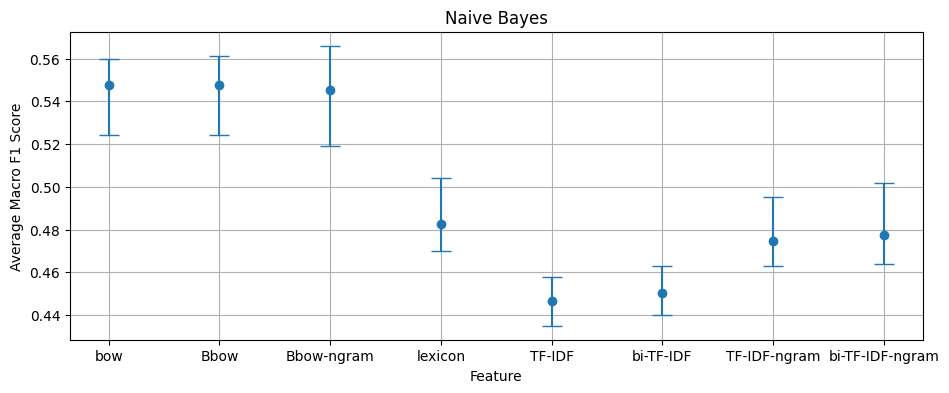

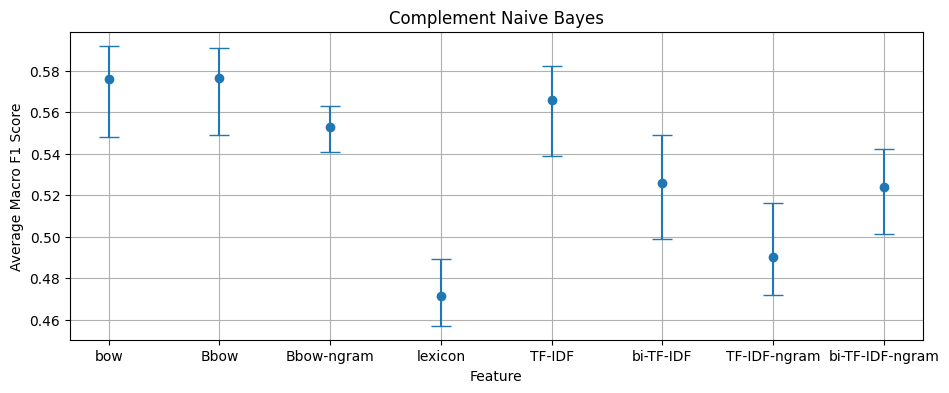

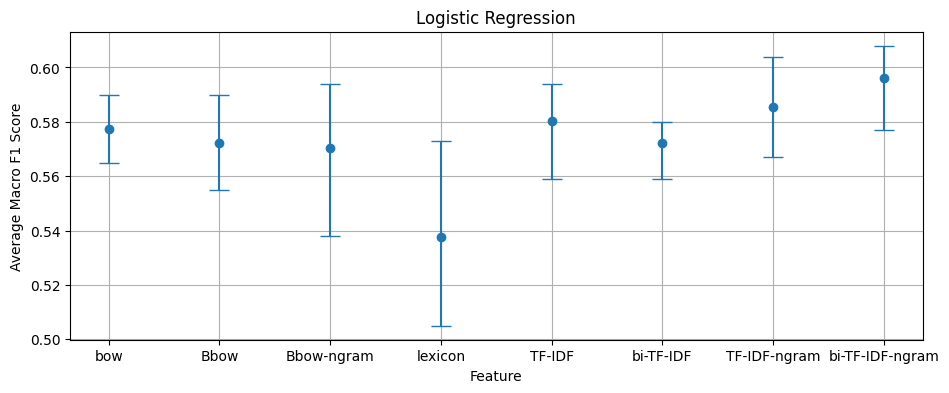

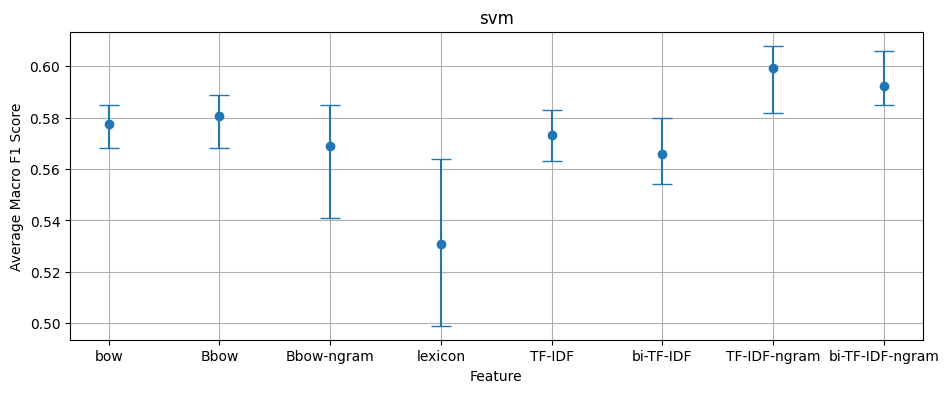

In [12]:
# Given data
for i, classifier in enumerate(CLASSIFIER):
    f = plt.figure(figsize=(11,4))
    #plt.plot(arr[i], marker='o', linestyle='')
    plt.errorbar(np.arange(len(FEATURES)),avg[i], yerr=[avg[i]-minimum[i], maximum[i]-avg[i]], fmt='o', capsize=7)

    plt.xticks(ticks=range(len(FEATURES)), labels=FEATURES)
    plt.xlabel('Feature')
    plt.ylabel('Average Macro F1 Score')
    plt.title(classifier)
    plt.grid(True)
    plt.savefig(os.path.join('plot', 'main_plot_'+classifier))
plt.show()

#### LSTM Classifier
The following code trains LSTM classifier with various features and prints the macro f1 scores across three test sets.

We define functions for building the embedding matrix and initialisating a neural classifier based on LSTM using PyTorch.

In [13]:
# Set the device to perform the computation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM Glove embedding matrix
def Glove(max_words = 400000):
    # Download the GloVe word embeddings and
    # map each word in the dataset into its pre-trained GloVe word embedding
    glove_dict = {}
    glove_words = {}
    V_most_freq = [word for word, freq in sorted(V_freq.items(), key=lambda item: item[1], reverse=True)]
    V_most_freq_max_words = V_most_freq[:max_words]
    #print(len(V_most_freq_max_words))
    embedding_matrix = np.zeros((max_words + 1, 100))
    with open("glove.6B.100d.txt","r", encoding="utf-8") as f:
        i = 1
        for line in f:
            line_split = line.split()
            word = line_split[0]
            vec = [float(i) for i in line_split[1:]]
            glove_dict[word] = vec
            if word in V_most_freq_max_words:
                glove_words[word] = i
                embedding_matrix[i] = np.array(vec)
                del glove_dict[word]
                i += 1
            if i > max_words:
                break
        print(i)
        if i <= max_words:
            for j in range(max_words,len(V_most_freq)):
                V_word = V_most_freq[j]
                if V_word in glove_dict:
                    glove_words[V_word] = i
                    embedding_matrix[i] = glove_dict[V_word]
                    del glove_dict[V_word]
                    i += 1
                if i > max_words:
                    break
    print('embedding_matrix:')
    print(embedding_matrix)
    print('Size:', embedding_matrix.shape)
    return glove_words, torch.tensor(embedding_matrix, dtype=torch.float32)

setup_seed(42)
# Initialise a neural model based on LSTM using PyTorch
class LSTMClassifier(nn.Module):
    def __init__(self, 
                 out_transform = 'mean',
                 max_words = 5000, 
                 embedding_dim = 100, 
                 hidden_dim = 256, 
                 num_classes = 3,
                 bidirectional = False,
                ):
        super(LSTMClassifier, self).__init__()
        self.out_transform = out_transform
        self.bidirectional = bidirectional
        # Load Glove
        self.glove_words, self.embedding_matrix = Glove(max_words = max_words)
        
        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(self.embedding_matrix, freeze=False)
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=hidden_dim, 
                            batch_first=True, 
                            dropout=0.5,
                            num_layers=2, 
                            bidirectional=self.bidirectional
                           )

        # Classifier Layer
        if self.bidirectional:
            self.linear = nn.Linear(hidden_dim*2, num_classes)
        else:
            self.linear = nn.Linear(hidden_dim, num_classes)

        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        # Forward pass through the embedding layer
        x = self.embedding(x)
        
        # Forward pass through the LSTM layer
        out, (hn, cn) = self.lstm(x)
        
        # Take the output of the last LSTM cell
        if self.out_transform == 'mean':
            out = out.mean(dim=1)
        elif self.out_transform == 'max':
            out, _ = out.max(dim=1)
        elif self.out_transform == 'final':
            if self.bidirectional:
                torch.cat((hn[-2], hn[-1]), dim=1)
            else:
                out = hn[-1]
        else:
            out = out.mean(dim=1) # default

        out = self.dropout(out)
        
        # Pass through the fully connected layer (classifier)
        out = self.linear(out)
        
        return out

##### Mean Pooling
We take the mean of the hidden states.

##### Max Pooling
We take the maximum of the hidden states.

We load from pickle if there is a trained model, or build a new one.

In [14]:
out_transform = 'mean'

In [15]:
if boo4 and os.path.exists(os.path.join('lstm', 'lstm_mean.pth')):
    print('Loading LSTM model from PyTorch file...')
    LSTM = LSTMClassifier(out_transform = out_transform)
    LSTM.load_state_dict(torch.load(os.path.join('lstm', 'lstm_mean.pth'),weights_only=False))
    print('LSTM is loaded from PyTorch.')
else:
    print('Initializing a neural model based on LSTM...')
    LSTM = LSTMClassifier(out_transform = out_transform)
    torch.save(LSTM.state_dict(), os.path.join('lstm', 'lstm_mean.pth'))
    try:
        del best_valid_loss, learning_rate_save, epochs_without_improvement
        print('Previous records are removed.')
    except:
        pass
torch.cuda.empty_cache()
gc.collect()

Loading LSTM model from PyTorch file...
4048
embedding_matrix:
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.038194 -0.24487   0.72812  ... -0.1459    0.8278    0.27062 ]
 [-0.1529   -0.24279   0.89837  ... -0.591     1.0039    0.20664 ]
 ...
 [ 0.33683   0.14787  -0.01302  ... -0.65636  -0.22344   0.72148 ]
 [ 0.62721   0.31214  -0.13404  ...  0.13873  -0.42523   0.73952 ]
 [-0.23013   0.28106   0.29434  ... -0.50042   0.25439   0.31675 ]]
Size: (5001, 100)
LSTM is loaded from PyTorch.


10

In [16]:
glove_words, embedding_matrix = LSTM.glove_words, LSTM.embedding_matrix
Y_gts = {'positive': 1,
         'negative': 2,
         'neutral': 0}

X_LSTM = [tweet.split() for tweet in tweets['twitter-training-data.txt']]
Y_LSTM = torch.tensor([Y_gts[gt] for gt in tweetgts['twitter-training-data.txt']], dtype=torch.long)
X_dev = [tweet.split() for tweet in tweets['twitter-dev-data.txt']]
Y_dev = torch.tensor([Y_gts[gt] for gt in tweetgts['twitter-dev-data.txt']], dtype=torch.long)

max_len = max(len(tweet) for tweet in X_LSTM)
print(f'Number of tokens of the longest tweet in training data: {max_len}.')

def tokens_to_indices(tokenized_tweets):
    global max_len
    indexed_tweets = []
    for tweet in tokenized_tweets:
        indexed_tweet = [glove_words.get(word, 0) for word in tweet]
        indexed_tweets.append(indexed_tweet[:max_len] + [0] * (max_len - len(indexed_tweet)))
    return torch.tensor(indexed_tweets, dtype=torch.long)

X_LSTM = tokens_to_indices(X_LSTM)
X_dev = tokens_to_indices(X_dev)

train_dataset = TensorDataset(X_LSTM, Y_LSTM)
dev_dataset = TensorDataset(X_dev, Y_dev)

batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

for X, Y in train_loader:
    print("X: ", X)
    Y_preds = LSTM(X)
    print("Prediction shape: ", Y_preds.shape)
    break

gc.collect()
torch.cuda.empty_cache()

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    # -- Disable the gradient --
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss  = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds    = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))
        print(classification_report(Y_shuffled.detach().numpy(), Y_preds.detach().numpy()))
    return torch.tensor(losses).mean(), accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())

# Evaluate on the Test Set - Compute the statistics for the Confusion Matrix
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_gts_inverse = {
    1: 'positive',
    0: 'neutral',
    2: 'negative'
}

def eva(testsets=testsets,verbose=True):
    F1 = []
    for testset in testsets:
        id_preds = {}
        X_test = [tweet.split() for tweet in tweets[testset]]
        #print(max(len(tweet)  for tweet in X_test))
        X_test = tokens_to_indices(X_test)
        Y_test = torch.tensor([Y_gts[gt] for gt in tweetgts[testset]])
        test_dataset = TensorDataset(X_test, Y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        Y_actual, Y_preds = MakePredictions(LSTM, test_loader)
        #print(Y_actual)
        #print(Y_preds)
        #print(len(Y_preds))
        for tweetid, prediction in zip(tweetids[testset], Y_preds):
            id_preds[tweetid] = Y_gts_inverse[prediction]
        #print(len(tweetids[testset]))
        testset_name = testset
        testset_path = join('semeval-tweets', testset_name)
        f1 = evaluate(id_preds, testset_path, 'LSTM', verbose=verbose)
        F1.append(f1)
    if verbose:
        print('maximum:', max(F1))
        print('minimum:', min(F1))
        print('average:', sum(F1)/len(F1))
    return max(F1), min(F1), round(sum(F1)/len(F1),3)

patience = 5
epochs_without_improvement = 0
try:
    if not boo4:
        1/0
    LSTM.load_state_dict(torch.load(os.path.join('lstm', 'lstm_mean.pth'),weights_only=False))
    best_valid_loss
    epochs_without_improvement
    last_avg
    learning_rate = learning_rate_save
    print('Training an existing neural model')
except:
    best_valid_loss = float('inf')
    learning_rate = 1e-03
    learning_rate_save = learning_rate
    epochs_without_improvement = 0
    last_avg = 0
    print('Training a new neural model')

# Training Loop
def TrainingLoop(model, loss_fn, optimizer, scheduler, train_loader, val_loader, file_location, epochs=10):
    global best_valid_loss
    global learning_rate_save
    global epochs_without_improvement
    global last_avg
    best_epoch = 0
    MAX = []
    MIN = []
    AVG = []
    epochs_used = 0
    for i in range(1, epochs+1):
        print('Epoch:',i)
        losses = []
        # Cycle over the training examples (using minibatches)
        # X are the examples, Y are the associated labels
        for X, Y in tqdm(train_loader):
            # Make the prediction
            Y_preds = model(X)

            # Compute the loss
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            # Reset the gradient
            optimizer.zero_grad()
            
            # Compute the gradient
            loss.backward()
            
            # Update the weights
            optimizer.step()

            del Y_preds
            gc.collect()
            torch.cuda.empty_cache()
        
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        train_loss = torch.tensor(losses).mean()
        valid_loss, valid_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)

        """
        print("\nGradient Check:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"{name}: Mean Gradient = {param.grad.abs().mean().item()}")

        print("\n" + "-"*50)
        """
        gc.collect()
        torch.cuda.empty_cache()
        scheduler.step(valid_loss)
        print(scheduler.get_last_lr())
        learning_rate_save = scheduler.get_last_lr()
        learning_rate_save = learning_rate_save[-1]
        maximum, minimum, avg = eva()
        MAX.append(maximum)
        MIN.append(minimum)
        AVG.append(avg)

        
        _, _, avg = eva(testsets=['twitter-dev-data.txt'], verbose=False)
        if valid_loss < best_valid_loss:
            epochs_without_improvement = 0
            best_valid_loss = valid_loss
            best_epoch = i
            torch.save(model.state_dict(), file_location)
            print('This model is better.')
        elif valid_loss == best_valid_loss and avg > last_avg:
            last_avg = avg
            epochs_without_improvement = 0
            best_valid_loss = valid_loss
            best_epoch = i
            torch.save(model.state_dict(), file_location)
            print('This model is better.')
        else:
            epochs_without_improvement += 1
            model.load_state_dict(torch.load(file_location,weights_only=False))
            print('Last model is better.')
            if epochs_without_improvement >= patience:
                print(f'The model has not improved after {patience} epochs. Stopping training.') 
                print(f'A total of {i} epochs is used to train the model.')
                epochs_used = i
                break
            else:
                print(f'If the model does not improve after {patience - epochs_without_improvement} epochs, training will be terminated.')
        
        if i == epochs:
            print(f'{epochs} epochs has passed. Terminate training.')
            epochs_used = i

    return MAX, MIN, AVG, epochs_used, best_epoch

from torch.optim import Adam
 
epochs = 30

from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2]), y=Y_dev.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

# Loss Function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
#loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(LSTM.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=0,factor=0.5)

try:
    lstm_dict
except:
    lstm_dict = {}

# Training Loop
if lstm_train or not boo4:
    MAX, MIN, AVG, epochs_used, best_epoch = TrainingLoop(LSTM.to(DEVICE), loss_fn, optimizer, scheduler, train_loader, dev_loader, os.path.join('lstm', 'lstm_mean.pth'), epochs=epochs)
    lstm_dict[out_transform] = [MAX, MIN, AVG, epochs_used, best_epoch]

Number of tokens of the longest tweet in training data: 43.
X:  tensor([[3951,  690, 3019,  ...,    0,    0,    0],
        [1107,  182,    0,  ...,    0,    0,    0],
        [1683,    6,    1,  ...,    0,    0,    0],
        ...,
        [  71, 1231,   95,  ...,    0,    0,    0],
        [   0,    4,  590,  ...,    0,    0,    0],
        [  20,   62,  214,  ...,    0,    0,    0]])
Prediction shape:  torch.Size([512, 3])
Training a new neural model


We evaluate on the test sets.

In [17]:
eva()

semeval-tweets\twitter-test1.txt (LSTM): 0.662
semeval-tweets\twitter-test2.txt (LSTM): 0.645
semeval-tweets\twitter-test3.txt (LSTM): 0.606
maximum: 0.662
minimum: 0.606
average: 0.6376666666666666


(0.662, 0.606, 0.638)

The plot is only available if training a new neural classifier.

In [20]:
if not boo4:
    EPOCHS = np.arange(1,epochs_used+1)
    MAX = np.array(MAX)
    MIN = np.array(MIN)
    AVG = np.array(AVG)
    f1 = plt.figure(figsize=(12,5))
    plt.errorbar(EPOCHS, AVG, yerr=[AVG-MIN, MAX-AVG], fmt='o', capsize=7)
    plt.plot(EPOCHS, AVG, linestyle="--")
    plt.xticks(EPOCHS)
    plt.xlabel("epoch(s)")
    plt.ylabel("Macro F1 score")
    plt.title('LSTM_'+out_transform)
    plt.grid(True)
    plt.show()
    f1.savefig(os.path.join('plot','lstm_'+out_transform+'.png'))

#### Appendix

##### A. Choosing alpha for the additive-alpha smoothing for Naive Bayes
We run the sentiment analysis on Binary NB and Complement NB with different features on the development set of tweets using different values of alpha, and plot the average macro F1 score across three test sets for each alpha.

In [21]:
Y = tweetgts['twitter-training-data.txt']
try:
    with open(os.path.join('pickle','NBs_alpha.pkl'), 'rb') as f:
        CLF_alpha = pickle.load(f)
    print('Classifiers are loaded from pickle.')
except:
    CLF_alpha = {}
    with open(os.path.join('pickle','NBs_alpha.pkl'), "wb") as f:
        pickle.dump(CLF_alpha, f)

ALPHA = [0.01,0.05] + [round(n,2) for n in np.arange(0.1,1.01,0.1)]

MACROF1 = {alpha: [] for alpha in ALPHA}
for alpha in ALPHA:
    if alpha not in CLF_alpha:
        CLF_alpha[alpha] = {}
    #print(alpha)
    for classifier in [
        'Naive Bayes', 
        'Complement Naive Bayes'
    ]:
        if classifier not in CLF_alpha[alpha]:
            CLF_alpha[alpha][classifier] = {}
        for features in FEATURES:
            # Skeleton: Creation and training of the classifiers
            #print(f'{features}-{classifier}')
            
            vectorizer, X = FEATURES_VEC[features]

            try:
                clf = CLF_alpha[alpha][classifier][features]
                print(f'The classifier {classifier} with alpha = {alpha} and feature {features} is loaded from pickle.')
            except:
                print(f'Training {classifier} with {features} and alpha = {alpha}')
                if classifier == 'Naive Bayes':
                    clf = MultinomialNB(alpha = alpha)
                    clf.fit(X,Y)
        
                elif classifier == 'Complement Naive Bayes':
                    clf = ComplementNB(alpha = alpha)
                    clf.fit(X,Y)

                CLF_alpha[alpha][classifier][features] = clf
                with open(os.path.join('pickle','NBs_alpha.pkl'), "wb") as f:
                    pickle.dump(CLF_alpha, f)

            gc.collect()
              
            # Predition performance of the classifiers
            for testset in ['twitter-dev-data.txt']:
                id_preds = {}
                # write the prediction and evaluation code here
                test_vector = vectorizer.transform(tweets[testset])
                predictions = clf.predict(test_vector)
                for tweetid, prediction in zip(tweetids[testset], predictions):
                    id_preds[tweetid] = prediction
                testset_name = testset
                testset_path = join('semeval-tweets', testset_name)
                macrof1 = evaluate(id_preds, testset_path, features + '-' + classifier, verbose=False)
                Macrof1.append(macrof1)
                
                MACROF1[alpha].append(macrof1)

            gc.collect()

alpha_mat = {alpha: np.zeros((2,len(FEATURES))) for alpha in MACROF1}
for alpha in MACROF1:
    arr = np.array(MACROF1[alpha]).reshape(2,len(FEATURES))
    arr = arr.round(3)
    #print(alpha, arr)
    alpha_mat[alpha] = arr

Classifiers are loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature bow is loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature Bbow is loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature Bbow-ngram is loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature lexicon is loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature TF-IDF is loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature bi-TF-IDF is loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature TF-IDF-ngram is loaded from pickle.
The classifier Naive Bayes with alpha = 0.01 and feature bi-TF-IDF-ngram is loaded from pickle.
The classifier Complement Naive Bayes with alpha = 0.01 and feature bow is loaded from pickle.
The classifier Complement Naive Bayes with alpha = 0.01 and feature Bbow is loaded from pickle.
The classifier Complement Naive Bayes with alpha = 0.01 and

We plot the macro F1 score against each alpha value.

NB argmax
bow 0.4
Bbow 0.5
Bbow-ngram 0.2
lexicon 0.01
TF-IDF 0.05
bi-TF-IDF 0.05
TF-IDF-ngram 0.01
bi-TF-IDF-ngram 0.01
CNB argmax
bow 0.6
Bbow 0.6
Bbow-ngram 0.3
lexicon 0.01
TF-IDF 0.5
bi-TF-IDF 0.5
TF-IDF-ngram 0.1
bi-TF-IDF-ngram 0.2


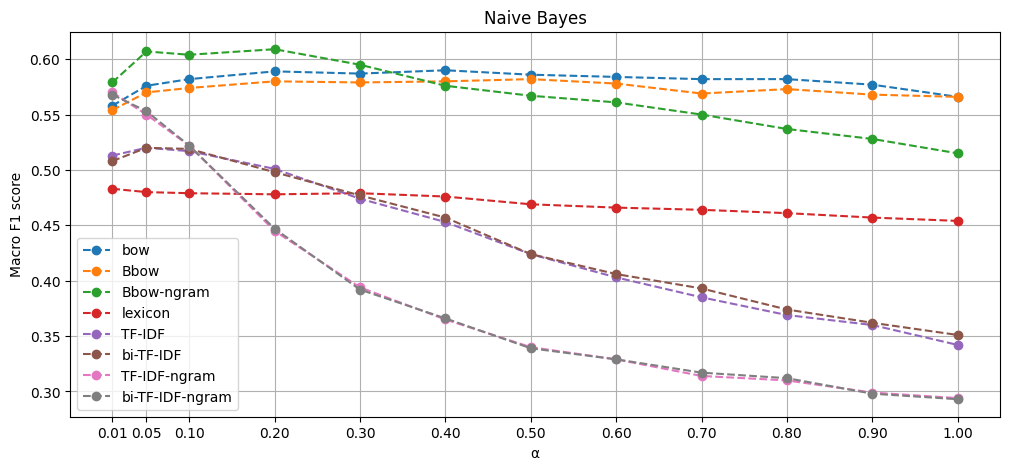

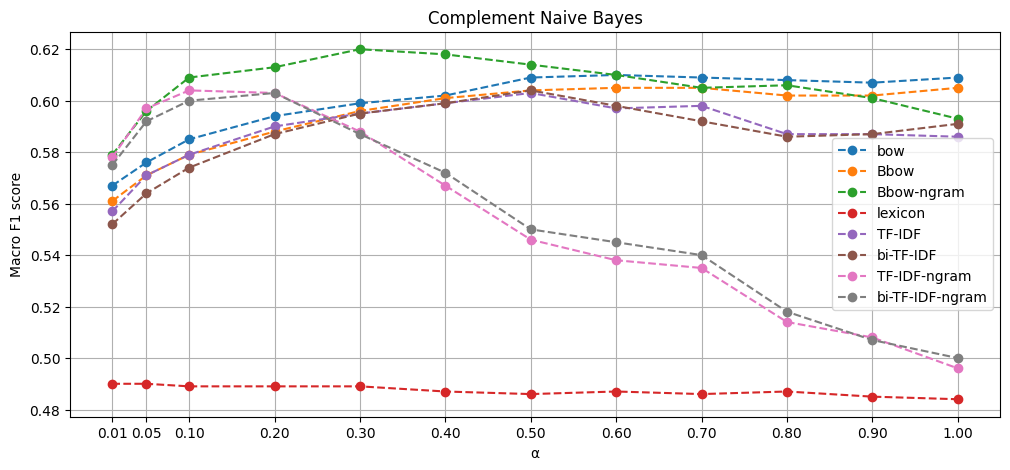

In [22]:
# Given data
labels = FEATURES
NB = np.zeros((len(alpha_mat),len(labels)))
CNB = np.zeros((len(alpha_mat),len(labels)))
for i, alpha in enumerate(alpha_mat):
    NB[i] = alpha_mat[alpha][0]
    CNB[i] = alpha_mat[alpha][1]
NB = NB.T
CNB = CNB.T

print('NB', 'argmax')
for i in range(len(labels)):
    print(labels[i], ALPHA[np.argmax(NB[i])])
print('CNB', 'argmax')
for i in range(len(labels)):
    print(labels[i], ALPHA[np.argmax(CNB[i])])

f1 = plt.figure(figsize=(12,5))
for i in range(len(labels)):
    plt.plot(ALPHA, NB[i], marker='o', linestyle='--', label=labels[i])
plt.xticks(ALPHA)
plt.xlabel("α")
plt.ylabel("Macro F1 score")
plt.legend()
plt.title('Naive Bayes')
plt.grid(True)

f2 = plt.figure(figsize=(12,5))
for i in range(len(labels)):
    plt.plot(ALPHA, CNB[i], marker='o', linestyle='--', label=labels[i])
plt.xticks(ALPHA)
plt.xlabel("α")
plt.ylabel("Macro F1 score")
plt.legend()
plt.title('Complement Naive Bayes')
plt.grid(True)

plt.show()
f1.savefig('alpha_NB_loose.png')
f2.savefig('alpha_CNB_loose.png')

We observe that there is roughly a peak for each plot. We zoom in near the peak to find the best the alpha values to the nearest 0.005. We note that some features perform not as good as others for all alpha values. Since we aim to build accurate classifiers, we do not investigate the best alpha values for such features to save time.

In [23]:
try:
    CLF_alpha
    print('Classifiers are already loaded.')
except:
    try:
        with open(os.path.join('pickle','NBs_alpha.pkl'), 'rb') as f:
            CLF_alpha = pickle.load(f)
        print('Classifiers are loaded from pickle.')
    except:
        CLF_alpha = {}
        with open(os.path.join('pickle','NBs_alpha.pkl'), "wb") as f:
            pickle.dump(CLF_alpha, f)

# Binary NB
ALPHA = [round(n,3) for n in np.arange(0.15, 0.551, 0.005)] 

MACROF1 = {alpha: [] for alpha in ALPHA}

for alpha in ALPHA:
    if alpha not in CLF_alpha:
        CLF_alpha[alpha] = {}
    #print(alpha)
    for classifier in [
        'Naive Bayes'
    ]:
        if classifier not in CLF_alpha[alpha]:
            CLF_alpha[alpha][classifier] = {}
        for features in [
            'bow',
            'Bbow', 
            'Bbow-ngram',
        ]:
            # Skeleton: Creation and training of the classifiers
            #print(f'{features}-{classifier}')
            vectorizer, X = FEATURES_VEC[features]

            try:
                clf = CLF_alpha[alpha][classifier][features]
                #print(f'The classifier {classifier} with alpha = {alpha} and feature {features} is loaded from pickle.')
            except:
                #print(f'Training {classifier} with {features} and alpha = {alpha}')
                if classifier == 'Naive Bayes':
                    # write the Naive Bayes here
                    #print('Training ' + classifier)
                    clf = MultinomialNB(alpha = alpha)
                    clf.fit(X,Y)

                CLF_alpha[alpha][classifier][features] = clf
                with open(os.path.join('pickle','NBs_alpha.pkl'), "wb") as f:
                    pickle.dump(CLF_alpha, f)

            gc.collect()
              
            # Predition performance of the classifiers
            for testset in ['twitter-dev-data.txt']:
                id_preds = {}
                # write the prediction and evaluation code here
                test_vector = vectorizer.transform(tweets[testset])
                predictions = clf.predict(test_vector)
                for tweetid, prediction in zip(tweetids[testset], predictions):
                    id_preds[tweetid] = prediction
                testset_name = testset
                testset_path = join('semeval-tweets', testset_name)
                macrof1 = evaluate(id_preds, testset_path, features + '-' + classifier, verbose=False)               
                MACROF1[alpha].append(macrof1)

            gc.collect()

alpha_mat = {alpha: np.zeros((1,3)) for alpha in MACROF1}
for alpha in MACROF1:
    arr = np.array(MACROF1[alpha]).reshape(1,3)
    arr = arr.round(3)
    #print(alpha, arr)
    alpha_mat[alpha] = arr

Classifiers are already loaded.


We plot the macro F1 score against each alpha value.

NB bow argmax: 0.26
NB Bbow argmax: 0.35
NB Bbow-ngram argmax: 0.15


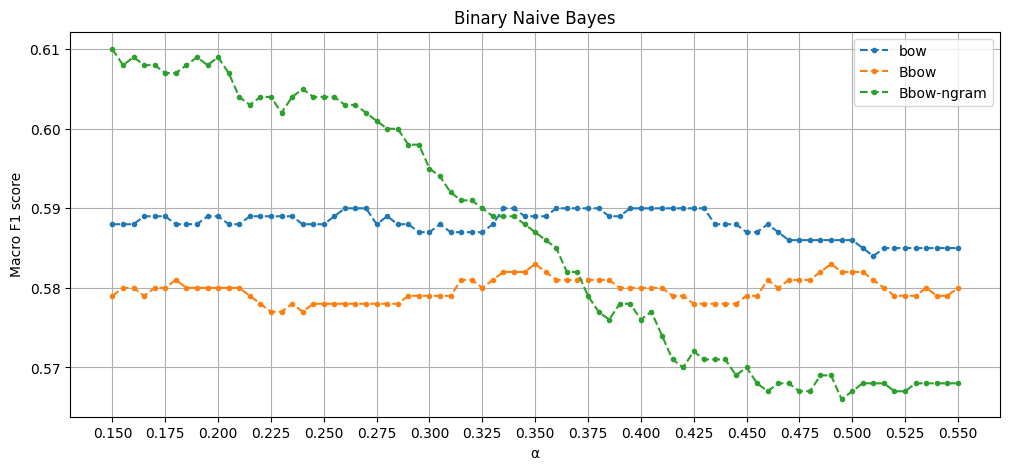

In [24]:
# Given data
labels = [
    'bow', 
    'Bbow',
    'Bbow-ngram'
]
NB = np.zeros((len(alpha_mat),3))
for i, alpha in enumerate(alpha_mat):
    NB[i] = alpha_mat[alpha][0]
NB = NB.T

for i in range(3):
    print('NB', labels[i], 'argmax:', ALPHA[np.argmax(NB[i])])

f1 = plt.figure(figsize=(12,5))
for i in range(3):
    plt.plot(ALPHA, NB[i], marker='.', linestyle='--', label=labels[i])
plt.xticks(list(set(round(a * 40) / 40 for a in ALPHA)))
plt.xlabel("α")
plt.ylabel("Macro F1 score")
plt.legend()
plt.title('Binary Naive Bayes')
plt.grid(True)
f1.savefig('alpha_NB_tight.png')

In [25]:
try:
    CLF_alpha
    print('Classifiers are already loaded.')
except:
    try:
        with open(os.path.join('pickle','NBs_alpha.pkl'), 'rb') as f:
            CLF_alpha = pickle.load(f)
        print('Classifiers are loaded from pickle.')
    except:
        CLF_alpha = {}
        with open(os.path.join('pickle','NBs_alpha.pkl'), "wb") as f:
            pickle.dump(CLF_alpha, f)

ALPHA = [round(n,3) for n in np.arange(0.25, 0.751, 0.005)] 

MACROF1 = {alpha: [] for alpha in ALPHA}

for alpha in ALPHA:
    if alpha not in CLF_alpha:
        CLF_alpha[alpha] = {}
    #print(alpha)
    for classifier in [
        'Complement Naive Bayes'
    ]:
        if classifier not in CLF_alpha[alpha]:
            CLF_alpha[alpha][classifier] = {}
        for features in [
            'bow', 
            'Bbow',
            'Bbow-ngram',
            'TF-IDF', 
            'bi-TF-IDF',
        ]:
            # Skeleton: Creation and training of the classifiers
            #print(f'{features}-{classifier}')
            vectorizer, X = FEATURES_VEC[features]

            try:
                clf = CLF_alpha[alpha][classifier][features]
            except:
                if classifier == 'Complement Naive Bayes':
                    """
                    Complement Naive Bayes is a variation of Naive Bayes
                    that is particularly suited for imbalanced data sets. 
                    Specifically, CNB uses statistics from the complement of each class 
                    to compute the model’s weights.
                    """
                    clf = ComplementNB(alpha = alpha)
                    clf.fit(X,Y)

                CLF_alpha[alpha][classifier][features] = clf

            gc.collect()
              
            # Predition performance of the classifiers
            for testset in ['twitter-dev-data.txt']:
                id_preds = {}
                # write the prediction and evaluation code here
                test_vector = vectorizer.transform(tweets[testset])
                predictions = clf.predict(test_vector)
                for tweetid, prediction in zip(tweetids[testset], predictions):
                    id_preds[tweetid] = prediction
                testset_name = testset
                testset_path = join('semeval-tweets', testset_name)
                macrof1 = evaluate(id_preds, testset_path, features + '-' + classifier, verbose=False)               
                MACROF1[alpha].append(macrof1)

            gc.collect()

alpha_mat = {alpha: np.zeros((1,5)) for alpha in MACROF1}
for alpha in MACROF1:
    arr = np.array(MACROF1[alpha]).reshape(1,5)
    arr = arr.round(3)
    #print(alpha, arr)
    alpha_mat[alpha] = arr

Classifiers are already loaded.


We plot the macro F1 score against each alpha value.

CNB bow argmax: 0.635
CNB Bbow argmax: 0.62
CNB Bbow-ngram argmax: 0.33
CNB TF-IDF argmax: 0.49
CNB bi-TF-IDF argmax: 0.485


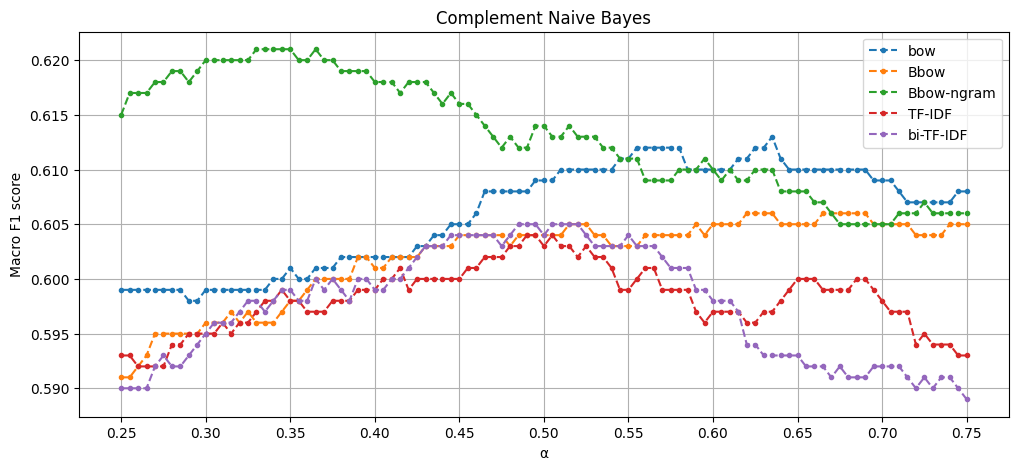

In [26]:
# Given data
labels = [
    'bow', 
    'Bbow',
    'Bbow-ngram',
    'TF-IDF', 
    'bi-TF-IDF',
]
CNB = np.zeros((len(alpha_mat),5))
for i, alpha in enumerate(alpha_mat):
    CNB[i] = alpha_mat[alpha]
CNB = CNB.T

for i in range(5):
    print('CNB', labels[i], 'argmax:', ALPHA[np.argmax(CNB[i])])

f2 = plt.figure(figsize=(12,5))
for i in range(5):
    plt.plot(ALPHA, CNB[i], marker='.', linestyle='--', label=labels[i])
plt.xticks([0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75])
plt.xlabel("α")
plt.ylabel("Macro F1 score")
plt.legend()
plt.title('Complement Naive Bayes')
plt.grid(True)

plt.show()
f2.savefig('alpha_CNB_tight.png')

##### B. Choosing C for regularisation for Logistics regression and SVM
We run the sentiment analysis onLogistics regression and SVM with different features on the development set of tweets using different values of C (i.e. inverse strength of regularisation), and plot the average macro F1 score across three test sets for each alpha.

In [27]:
import time
Y = tweetgts['twitter-training-data.txt']
try:
    with open(os.path.join('pickle','CLF_C.pkl'), 'rb') as f:
        CLF_C = pickle.load(f)
except:
    CLF_C = {}
    with open(os.path.join('pickle','CLF_C.pkl'), "wb") as f:
        pickle.dump(CLF_C, f)


C = [10**n for n in [-2,-1.5,-1,-0.5,0,0.5,1,1.5]]

MACROF1 = {c: [] for c in C}
TIME = {c: [] for c in C}


for c in C:
    print(c)
    if c not in CLF_C:
        CLF_C[c] = {}
    for classifier in [
        'Logistic Regression'
        , 
        'svm'
    ]:
        if classifier not in CLF_C[c]:
            CLF_C[c][classifier] = {}
        for features in FEATURES:
            # Skeleton: Creation and training of the classifiers
            #print(f'{features}-{classifier}')
            
            vectorizer, X = FEATURES_VEC[features]

            try:
                clf, t = CLF_C[c][classifier][features]
                TIME[c].append(t)
            except:
                a = time.time()
                if classifier == 'Logistic Regression':
                    # write the Logistic Regression here
                    #print('Training ' + classifier)
                    """
                    Multinomial logistic regression
                    """
                    clf = LogisticRegression(solver='saga', C=c, max_iter=5000, n_jobs=-1)
                    clf.fit(X, Y)
        
                elif classifier == 'svm':
                    # write the svm classifier here
                    #print('Training ' + classifier)
                    """
                    Support Vector Machine (SVM)
                    """
                    clf = LinearSVC(C=c, max_iter=5000)
                    clf.fit(X,Y) 
                b = time.time()
                t=b-a
                print('Time taken:', t)
                TIME[c].append(t)
                CLF_C[c][classifier][features] = (clf, t)
                with open(os.path.join('pickle','CLF_C.pkl'), "wb") as f:
                    pickle.dump(CLF_C, f)
              
            # Predition performance of the classifiers
            for testset in ['twitter-dev-data.txt']:
                id_preds = {}
                # write the prediction and evaluation code here
                test_vector = vectorizer.transform(tweets[testset])
                predictions = clf.predict(test_vector)
                for tweetid, prediction in zip(tweetids[testset], predictions):
                    id_preds[tweetid] = prediction
                testset_name = testset
                testset_path = join('semeval-tweets', testset_name)
                macrof1 = evaluate(id_preds, testset_path, features + '-' + classifier, verbose=True)

                MACROF1[c].append(macrof1)
            
            
            gc.collect()

C_mat = {c: np.zeros((2,len(FEATURES))) for c in MACROF1}
TIME_mat = {t: np.zeros((2,len(FEATURES))) for time in TIME}
for c in MACROF1:
    arr = np.array(MACROF1[c]).reshape(2,len(FEATURES))
    arr = arr.round(3)
    #print(c, arr)
    C_mat[c] = arr
for t in TIME:
    TIME_mat[t] = np.array(TIME[t]).reshape(2,len(FEATURES)).round(3)

0.01
semeval-tweets\twitter-dev-data.txt (bow-Logistic Regression): 0.485
semeval-tweets\twitter-dev-data.txt (Bbow-Logistic Regression): 0.474
semeval-tweets\twitter-dev-data.txt (Bbow-ngram-Logistic Regression): 0.488
semeval-tweets\twitter-dev-data.txt (lexicon-Logistic Regression): 0.303
semeval-tweets\twitter-dev-data.txt (TF-IDF-Logistic Regression): 0.220
semeval-tweets\twitter-dev-data.txt (bi-TF-IDF-Logistic Regression): 0.223
semeval-tweets\twitter-dev-data.txt (TF-IDF-ngram-Logistic Regression): 0.111
semeval-tweets\twitter-dev-data.txt (bi-TF-IDF-ngram-Logistic Regression): 0.096
semeval-tweets\twitter-dev-data.txt (bow-svm): 0.574
semeval-tweets\twitter-dev-data.txt (Bbow-svm): 0.569
semeval-tweets\twitter-dev-data.txt (Bbow-ngram-svm): 0.588
semeval-tweets\twitter-dev-data.txt (lexicon-svm): 0.434
semeval-tweets\twitter-dev-data.txt (TF-IDF-svm): 0.384
semeval-tweets\twitter-dev-data.txt (bi-TF-IDF-svm): 0.371
semeval-tweets\twitter-dev-data.txt (TF-IDF-ngram-svm): 0.293


LR argmax
bow 0.31622776601683794
Bbow 0.31622776601683794
Bbow-ngram 1
lexicon 3.1622776601683795
TF-IDF 3.1622776601683795
bi-TF-IDF 3.1622776601683795
TF-IDF-ngram 3.1622776601683795
bi-TF-IDF-ngram 31.622776601683793
SVM argmax
bow 0.1
Bbow 0.1
Bbow-ngram 0.31622776601683794
lexicon 31.622776601683793
TF-IDF 1
bi-TF-IDF 1
TF-IDF-ngram 1
bi-TF-IDF-ngram 10


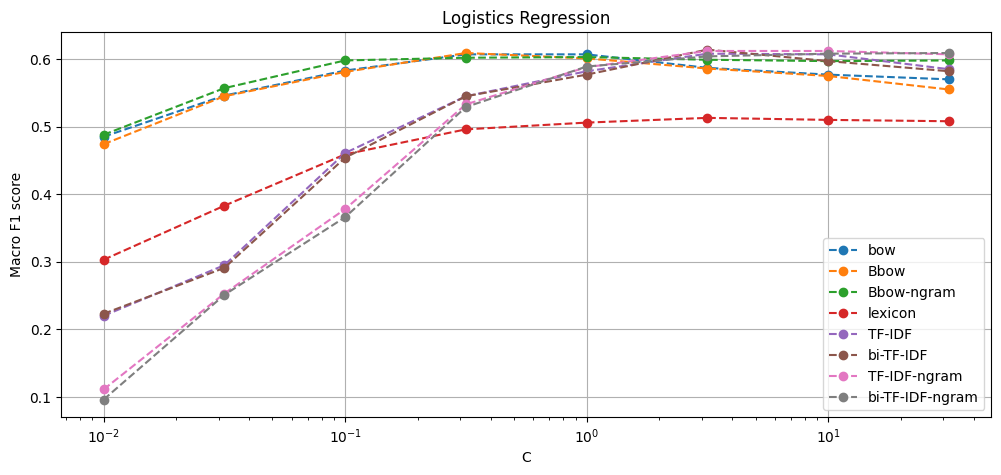

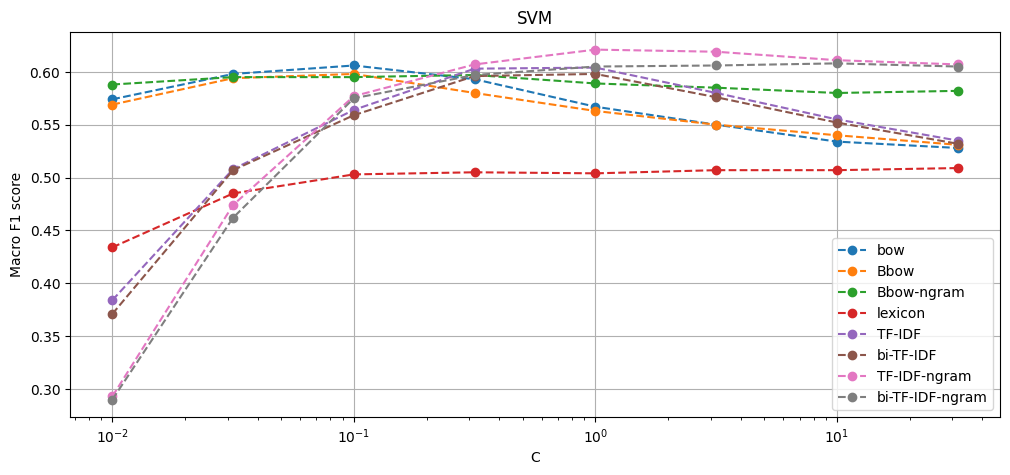

In [28]:
# Given data
C = [10**n for n in [-2,-1.5,-1,-0.5,0,0.5,1,1.5]]
labels = FEATURES
LR = np.zeros((len(C_mat),len(labels)))
SVM = np.zeros((len(C_mat),len(labels)))
for i, c in enumerate(C_mat):
    LR[i] = C_mat[c][0]
    SVM[i] = C_mat[c][1]
LR = LR.T
SVM = SVM.T

print('LR', 'argmax')
for i in range(len(labels)):
    print(labels[i], C[np.argmax(LR[i])])
print('SVM', 'argmax')
for i in range(len(labels)):
    print(labels[i], C[np.argmax(SVM[i])])

f1 = plt.figure(figsize=(12,5))
for i in range(len(labels)):
    plt.plot(C, LR[i], marker='o', linestyle='--', label=labels[i])
plt.xticks(C)
plt.xlabel("C")
plt.ylabel("Macro F1 score")
plt.legend()
plt.xscale("log")
plt.title('Logistics Regression')
plt.grid(True)

f2 = plt.figure(figsize=(12,5))
for i in range(len(labels)):
    plt.plot(C, SVM[i], marker='o', linestyle='--', label=labels[i])
plt.xticks(C)
plt.xlabel("C")
plt.ylabel("Macro F1 score")
plt.legend()
plt.xscale("log")
plt.title('SVM')
plt.grid(True)

plt.show()
f1.savefig('c_lr.png')
f2.savefig('c_svm.png')